### ADVANCED ML(2020, 2nd semester): TEAM 3, OUTLIER DETECTION, ROCF PART.<br>
<div style="text-align: right"><h3> Dept. of Data Science, Jicheol, Kang</h3></div>

In [25]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 
from sklearn.datasets import make_moons
from sklearn.metrics import pairwise_distances 
from scipy.sparse.csgraph import connected_components
import warnings; warnings.filterwarnings("ignore")

Algorithms in here are based on:<br>
- **MkNN(Mutual k-Nearest Neighbors)**: Maier, Hein, Luxburg. (2009). Optimal construction of k-nearest-neighbor graphs for identifying noisy clusters. Theoretical Computer Science, Volume 410, Issue 19, pp1749-1764.
- **ROCF(Relative Outlier Cluster Factor)**: Huang et al. (2017). A novel outlier cluster detection algorithm without top-n parameter. Knowledge-Based Systems, Vol.121. pp32-40.

### Datasets

**Input data shape: M x N array type**<br>
M: # of data, N: # of feature

In [22]:
dataset = 'ring' # or 'blob', 'moon'

In [23]:
if dataset == 'ring':
    X, y = make_blobs(n_samples=250, centers=5, n_features=2, random_state=3)
    data= X
elif dataset == 'blob':
    data_df= pd.read_csv('https://drive.google.com/uc?export=download&id=1_ygiOJ-xEPVSIvj3OzYrXtYc0Gw_Wa3a')
    data= data_df.values
else:
    X, y= make_moons(n_samples=150, noise=0.1)
    data= X

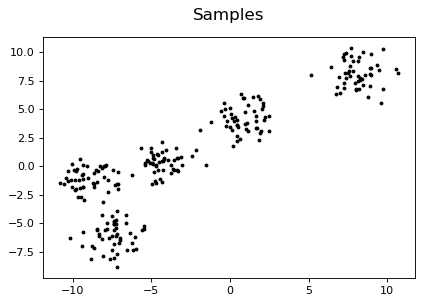

In [24]:
plt.figure(figsize=(6,4), dpi=80)
plt.title('Samples', pad=15, size=15)
plt.scatter(data[:,0], data[:,1], s=6, c='k')

### Settings

In [6]:
k= 5
outlier_threshold= 1
ROCF_threshold= 0.6

### MkNN outlier detection(scatter outlier)

In [7]:
def MkNN_outlier(data, k, outlier_threshold):
    idx_pre= [i for i in np.where(data[:,0])[0]]; idx= [(i, j) for i in idx_pre for j in idx_pre]
    
    data_dist_mtx = pairwise_distances(data, metric='euclidean')
    data_dist_mtx[::1].sort()
    
    adj= np.zeros((len(data), len(data)))
    
    for i, j in idx:
        dist= np.linalg.norm(data[i]-data[j])
    
        if dist <= data_dist_mtx[i][k] and dist <= data_dist_mtx[j][k]:
            adj[i, j]= 1
    
    n_components, labels= connected_components(csgraph=adj, directed=False, return_labels=True)
    clusters= np.unique(labels)
    
    scatter_outlier= []
    for k in clusters:
        a, = np.where(labels==k)
        if len(a) <= outlier_threshold:
            for i in a:
                scatter_outlier.append(int(i))
                
    return scatter_outlier, clusters, labels, adj

In [8]:
scatter_outliers_result, clusters, labels, adj= MkNN_outlier(data, k, outlier_threshold)
scatter_outliers= scatter_outliers_result;
print(scatter_outliers); print(clusters)

[3, 82, 128]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


### ROCF outlier detection(cluster outlier)

In [9]:
def ROCF_outlier(data, clusters, outlier_threshold, ROCF_threshold):
    cluster_size= {}
    for k in clusters:
        a, = np.where(labels==k)
        if len(a) > outlier_threshold:
            cluster_size[k]= len(a)
    
    cluster_size_sorted_dic= {k: v for k, v in sorted(cluster_size.items(), key=lambda item: item[1])}
    cluster_size_sorted= list(cluster_size_sorted_dic.keys())
    
    cluster_ROCF= {}
    for k in cluster_size_sorted[:-1]:
        a, = np.where(labels==k)
        b, = np.where(labels==k+1)

        TL= len(b)/len(a)
        ROCF= 1-np.exp(-(TL/len(a)))
        cluster_ROCF[k]= ROCF
    
    for idx, val in enumerate(cluster_size_sorted[:-1]):
        if cluster_ROCF[val] >= ROCF_threshold:
            cluster_outlier= cluster_size_sorted[0:idx+1]
            break
        
    return cluster_ROCF, cluster_outlier

In [10]:
cluster_ROCF, cluster_outlier= ROCF_outlier(data, clusters, outlier_threshold, ROCF_threshold)
print(cluster_ROCF); print(cluster_outlier)

{11: 0.5276334472589853, 13: 0.22119921692859512, 5: 0.960133632176275, 12: 0.19926259708319194, 17: 0.0, 16: 0.17097088181959963, 9: 0.27385096292630906, 8: 0.07515118678379518, 10: 0.03076676552365587, 7: 0.024389019935154077, 0: 0.0664866359180043, 6: 0.02117567078583471, 1: 0.023515739266867786, 2: 0.0005163955475199211}
[11, 13, 5]


### Visualization

In [11]:
idx_pre= [i for i in np.where(data[:,0])[0]]; idx= [(i, j) for i in idx_pre for j in idx_pre]

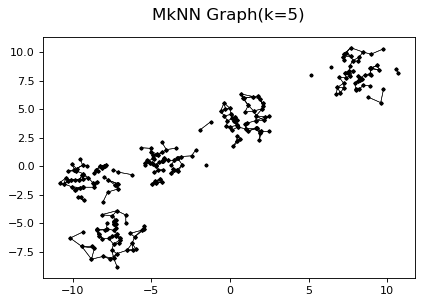

In [12]:
plt.figure(figsize=(6,4), dpi=80)
plt.title('MkNN Graph(k=5)', pad=15, size=15)
plt.scatter(data[:,0], data[:,1], s=6, c='k')
for i, j in idx:
    if adj[i, j]==1:
        plt.plot([data[:,0][i], data[:,0][j]], [data[:,1][i], data[:,1][j]], 'ko-', linewidth=0.5, markersize=2)

In [13]:
y_rocf= list(cluster_ROCF.values())

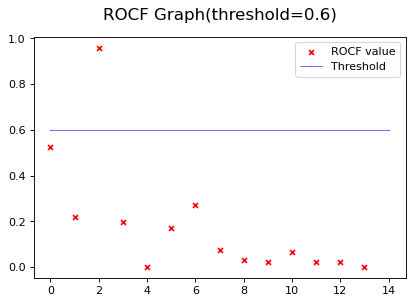

In [14]:
plt.figure(figsize=(6,4), dpi=80)
plt.title('ROCF Graph(threshold=0.6)', pad=15, size=15)
rf= plt.scatter(range(len(y_rocf)), y_rocf, s=20, marker='x', c='r')
th= plt.plot((0, len(y_rocf)), (ROCF_threshold, ROCF_threshold), 'bo-', linewidth=0.5, markersize=0.1, label="Threshold")
plt.legend([rf, th[0]],["ROCF value","Threshold"])

In [15]:
data[:,1][labels==cluster_outlier]

array([], shape=(0, 250), dtype=float64)

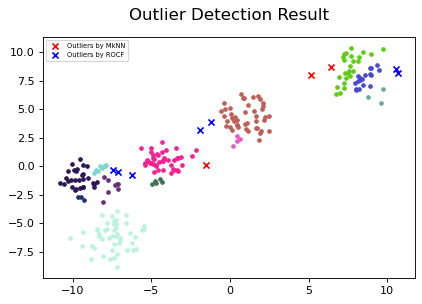

In [32]:
plt.figure(figsize=(6,4), dpi=80)
plt.title('Outlier Detection Result', pad=15, size=15)
sc= plt.scatter(data[:,0][scatter_outliers], data[:,1][scatter_outliers], marker='x', color='r', s=30)
for i in cluster_outlier:
    cl= plt.scatter(data[:,0][labels==i], data[:,1][labels==i], marker='x', color='b', s=30)
plt.legend([sc, cl],["Outliers by MkNN", "Outliers by ROCF"], prop={'size': 6});
for k in clusters:
    a, = np.where(labels==k)
    if len(a) > outlier_threshold and k not in cluster_outlier:
        plt.scatter(data[:,0][a], data[:,1][a], marker='o', color=np.random.rand(3,) , s=10)

### Metrics

**Precision**: TP/PN(# of the true outliers that dataset) <br>
**Recall**: TP/TP+FP

In [33]:
scatter= []
scatter.append(scatter_outliers)

In [34]:
for k in clusters:
    a, = np.where(labels==k)
    if (len(a) > outlier_threshold and k in cluster_outlier):
        a_list= [i for i in a]
        scatter.append(a_list)
total_outliers= []
for i in range(len(scatter)):
    for j in scatter[i]:
        total_outliers.append(j)

In [35]:
real_outliers= [128, 7, 230, 244, 49, 61, 52, 23, 65, 11, 12, 71, 99, 15, 82, 49] # sample

In [36]:
true_positive= [i for i in total_outliers if i in real_outliers]; print('True positive outlier indices: ', true_positive);

True positive outlier indices:  [82, 128, 7, 230, 244, 49]


In [37]:
print('Outlier indices detected by algorithm: ', total_outliers); print('Total outlier counts detected by algorithm: ', len(total_outliers)); print('')
print('Real outlier indices: ', real_outliers); print('Total real outlier counts: ', len(real_outliers)); print('')
print('True positive outlier indices: ', true_positive); print('True positive outlier counts: ', len(true_positive))

Outlier indices detected by algorithm:  [3, 82, 128, 7, 230, 244, 49, 132, 76, 161]
Total outlier counts detected by algorithm:  10

Real outlier indices:  [128, 7, 230, 244, 49, 61, 52, 23, 65, 11, 12, 71, 99, 15, 82, 49]
Total real outlier counts:  16

True positive outlier indices:  [82, 128, 7, 230, 244, 49]
True positive outlier counts:  6


In [38]:
precision= len(true_positive)/len(real_outliers)
recall= len(true_positive)/len(total_outliers);
print('Precison: ', precision); print('Recall : ', recall)

Precison:  0.375
Recall :  0.6
